<a href="https://colab.research.google.com/github/mashyko/LSTM_RNN/blob/master/LSTM_sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM in Tensorflow 2.0

　adopted from https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf

Kerasでsin波の時系列を予測


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random



データの作成:Sin波の生成

In [0]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

# sin波にノイズを付与する
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

f = toy_problem()

Sin波をRNNに通すための形に成型

以下のように学習データとして25ステップ分につき,ラベルデータを1つで1つの学習データを表現する．


In [0]:
def make_dataset(low_data, n_prev=100):

    data, target = [], []
    maxlen = 25

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target


#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(f)

future_test = g[175].T



n_hidden: 隠れ層 -> 数が多い程，学習モデルの複雑さが増加

batch_input_shape: LSTMに入力するデータの形を指定([バッチサイズ，step数，特徴の次元数]を指定する）

Denseでニューロンの数を調節しているだけ．今回は，時間tにおけるsin波のy軸の値が出力なので，ノード数1にする．
線形の活性化関数を用いている．

compileで，誤差関数:最小2乗誤差，最適化手法: Adamを用いるように定義


In [0]:
# モデル構築

# 1つの学習データのStep数(今回は25)
length_of_sequence = g.shape[1] 
in_out_neurons = 1
n_hidden = 300

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)


学習

生成した学習データ，定義したモデルを用いて，学習を行う．

今回は，学習データの10%をvalidationに用いて，100 epochで学習させた．

1行目のearly_stoppingをcallbacksで定義することで，validationの誤差値(val_loss)の変化が収束したと判定された場合に自動で学習を終了する．modeをautoにすることで，収束の判定を自動で行う．

patienceは，判定値からpatienceの値の分だけのepochは学習して，変化がなければ終了するように判定する．なので，patience=0だと，val_lossが上昇した瞬間，学習が終了することになる．


In [0]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(g, h,
          batch_size=300,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Epoch 1/100
1/1 [==============================] - 0s 431ms/step - loss: 0.4940 - val_loss: 0.1080
Epoch 2/100
1/1 [==============================] - 0s 51ms/step - loss: 0.2939 - val_loss: 0.0387
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 0.1624 - val_loss: 0.1213
Epoch 4/100
1/1 [==============================] - 0s 47ms/step - loss: 0.1201 - val_loss: 0.2187
Epoch 5/100
1/1 [==============================] - 0s 46ms/step - loss: 0.1146 - val_loss: 0.1472
Epoch 6/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0725 - val_loss: 0.0649
Epoch 7/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0442 - val_loss: 0.0274
Epoch 8/100
1/1 [==============================] - 0s 50ms/step - loss: 0.0382 - val_loss: 0.0163
Epoch 9/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0395 - val_loss: 0.0139
Epoch 10/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0381 - val_loss: 0.0127
Epoch 11/100
1/1 [

学習データを予測して，sin波が再現できるか確認．

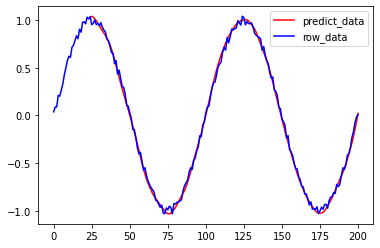

In [0]:
predicted = model.predict(g)
plt.figure()
plt.plot(range(25,len(predicted)+25),predicted, color="r", label="predict_data")
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.legend()
plt.show()

未来の予測

生成した学習モデルを用いて，学習データ以降の時間のsin波の座標を予測する．


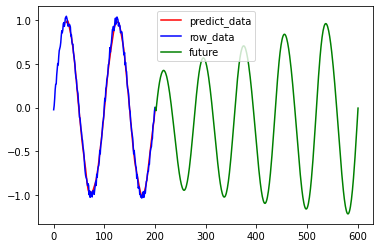

In [0]:
#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(f)

future_test = g[175].T
# 1つの学習データの時間の長さ -> 25
time_length = future_test.shape[1]
# 未来の予測データを保存していく変数
future_result = np.empty((1))

# 未来予想
for step2 in range(400):

    test_data = np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)

    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)

    future_result = np.append(future_result, batch_predict)

predicted = model.predict(g)

# sin波をプロット
plt.figure()
plt.plot(range(25,len(predicted)+25),predicted, color="r", label="predict_data")
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.plot(range(0+len(f), len(future_result)+len(f)), future_result, color="g", label="future")
plt.legend()
plt.show()

以上